In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import circ_corr as cc
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool
import scipy
import pickle
pi=np.pi
subjs = ['UCSD0' + x for x in ['54','60','61','62','63','64']]
n_subj = len(subjs)
rois = ['V1','V2','V3','V3AB','hV4','IPS0']

In [2]:
def sem_plot(x,y,axs=0,within_E=0,do_line=1,outline=0,**args):
    # x is assumed to be examples x len(y)
    n_ex,n_points =  y.shape
    if n_points!=len(x):
        y=y.T
        n_ex,n_points =  y.shape
    assert n_points==len(x), 'x not correct shape'
    if np.any(np.isnan(y)): 
        print('ignoring nan values!')
        n_ex = np.sum(~np.isnan(y),0)
    m_y = np.nanmean(y,0)
    
    if within_E:
        y_use = (y.T-np.mean(y,1)).T
        s_y = np.nanstd(y_use,0)/np.sqrt(n_ex)
    else:
        s_y = np.nanstd(y,0)/np.sqrt(n_ex)
    if axs==0:
        if outline:
            plt.plot(x,m_y+s_y,**args)
            plt.plot(x,m_y-s_y,**args)
        else:
            plt.fill_between(x,m_y-s_y,m_y+s_y,**args)
            if do_line:
                plt.plot(x,m_y,'k')
    else:
        if outline:
            axs.plot(x,m_y+s_y,**args)
            axs.plot(x,m_y-s_y,**args)
        else:
            axs.fill_between(x,m_y-s_y,m_y+s_y,**args)
            if do_line:
                axs.plot(x,m_y,'k')
            

import matplotlib 
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

import matplotlib
cmap = matplotlib.cm.get_cmap('Dark2')
ct = cmap(np.linspace(0,1,4))

In [3]:
def sav_fig(nam):
    root = './Figs/'
    plt.savefig(root + nam +'.svg',dpi=1200)
    
def circ_mean_rad(x): return np.angle(np.mean(np.exp(1j*x))) # rad --> rad
def circ_mean(x): return np.angle(np.mean(np.exp(1j*x/90*pi)))*90/pi # deg --> deg
def circ_std(x):
    R = np.abs(np.mean(np.exp(1j*x/90*pi)))
    v = np.sqrt(-2*np.log(R))
    return v
def inv_cdf(cdf,probe): return np.argmin(np.abs(np.expand_dims(cdf,1) - probe),0) # draws from 'y'-axis

# To Implement:
1. fitting a subject iteratively with cross-validation
1. evaluating goodness of fit(?) relative to null model?

Later Add
1. Fitting function 1 using max likelihood! 
1. Poisson noise



# Helper Functions

In [4]:
def do_bining(bns,overlap,grouping_var,var,var2=[-999],flip=1,prior_gauss=[4,0],want_var=0):
#     global obs, d_use_rad
    n_bns=len(bns)
    grouper = np.zeros(len(bns))
    if var2[0]!=-999:
        do_SDT=1

        out = np.zeros((2,len(bns)))
            
        if flip:
            grouping_var = np.concatenate((grouping_var,-grouping_var))
            var = np.concatenate((var,(var==0)*1))
            var2 = np.concatenate((var2,-var2))
    else:
        do_SDT=0
        out = np.zeros(len(bns))
        if flip:
            grouping_var = np.concatenate((grouping_var,-grouping_var))
            if flip==2:
                var = np.concatenate((var,var))
            elif flip==1:
                var = np.concatenate((var,-var))
    for i in range(n_bns):
        if overlap==0:
            if i==(n_bns-1):
                continue
            else:
                these_ind = (grouping_var>=bns[i])&(grouping_var<bns[i+1])
            
        elif i<overlap:
            these_ind = (grouping_var<=bns[i+overlap]) | (grouping_var>=bns[i-overlap])
        elif i>(n_bns-overlap-1):
            these_ind = (grouping_var>=bns[i-overlap]) | (grouping_var<=bns[i+overlap-n_bns])
        else:
            these_ind = (grouping_var>=bns[i-overlap])&(grouping_var<=bns[i+overlap]) # need to figure out 
            
        if do_SDT:
            dat_in = (var[these_ind],var2[these_ind])
            fit = scipy.optimize.minimize(min_fun_gauss,prior_gauss,args=(dat_in,),bounds=((0.01,45),(-45,45)) )
            out[:,i] = [fit.x[0],-fit.x[1]]
 
        else:
            if want_var==0:
                out[i] = np.nanmean(var[these_ind])
            elif want_var==1:
                out[i] = np.nanstd(var[these_ind])
            elif want_var==2:
                out[i] = circ_std(var[these_ind])
            elif want_var==3:
                out[i] = circ_mean(var[these_ind])
            elif want_var==4:
                out[i] = np.sum(wrap(var[these_ind]-circ_mean(var[these_ind]))**2)
            
    return out

def wrap(x):
    x[np.abs(x)>90]-=180*np.sign(x[np.abs(x)>90])
    return x

def wrap_rad(x):
    x[np.abs(x)>pi]-=2*pi*np.sign(x[np.abs(x)>pi])
    return x

GUESS_RATE = 0.25 

def min_fun_gauss(p,dat_in):
    # sd, bias
    obs,d_use_deg = dat_in
    G = scipy.stats.norm(p[1],p[0])
    lik = ((1-obs)*G.cdf(d_use_deg)+(obs)*(1-G.cdf(d_use_deg)))*(1-GUESS_RATE)+0.5*GUESS_RATE
    return -np.sum(np.log(lik))

def gauss(x,mu=0,sig=1): return 1/np.sqrt(2*pi*sig**2)*np.exp(-((x-mu)**2)/(2*sig**2))
def std_e(x): return np.std(x,0)/np.sqrt(len(x))

def rectify(x):
    if do_rectify:
        return np.minimum(0,x)
    else:
        return x

# Model Definitions

In [5]:
# Model defs
def poisson_expect(expect,actual): return expect**actual/scipy.special.factorial(actual) * np.exp(-expect)
def c(s_0,s_1=0,lam=10/90*pi,gamma=2): ## eq 7
    full = np.exp(-1/(2*lam**2)*np.abs(wrap_rad(s_0-s_1))**gamma)
    return full/np.sum(full,0)*len(s_0)

def cf(s_0,s_1=0,lam=20/90*pi,gamma=2,p_same=0.64): ## eq 6  #10, 2, 0.9 (note p_same from BB&J2019 empiricial prior)
    return p_same*c(s_0,s_1,lam,gamma) + (1-p_same)

def run_model_1(p,data,min_mode='RSS',do_poisson=0):
    # p - params 
    # data - dictionary
    # min_mode 
    # do_poisson - flag, value is Rate
    
    gam_1, gam_s = p # unpack
    this_ori_prev,this_ori_current,this_ori_dec = data['ori_prev'],data['ori_current'],data['ori_dec']

    # implement adaptation on population
#     adapt_shape = np.minimum(0,-gam_1*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s)**3) 
    adapt_shape = rectify(-gam_1*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s)**3)     #- adaptation shape (neuron x trial)
    gamma_a =adapt_shape+gamma_n -np.mean(adapt_shape,0)*add_constant_adapt #- normalized gain (neuron x trial)
    
    resp_a_stim = gamma_a*np.exp(kappa_a*np.cos(wrap_rad(Phi-this_ori_current))-1)  #- adapted response (neuron x trial)
    
    if do_poisson:
        ll_n_a_all = np.sum(np.log(poisson_expect(TC_n*do_poisson,np.expand_dims(resp_a_stim*do_poisson,2))),0)
    else:
        ll_n_a_all = np.sum(np.log(gauss(TC_n-np.expand_dims(resp_a_stim,2),0,sd)),0) # LL @ all ori (trial x orientation)

    if min_mode=='RSS': #     for minimizing L2 error
        max_lik = ori[np.argmax(ll_n_a_all,1)]
        e_model = wrap_rad(max_lik-this_ori_dec)
        RSS = np.mean(e_model**2)
        return RSS
    
    if min_mode=='decode':
        max_lik = ori[np.argmax(ll_n_a_all,1)]
        return max_lik
    
    if min_mode=='vis':
        max_lik = ori[np.argmax(ll_n_a_all,1)]
        E_this = wrap_rad(max_lik-this_ori_current)*90/pi
        return E_this

def run_model_2(p,data,min_mode='maxlik_gauss',model_mode='a_a',do_poisson=0):
    
    this_ori_prev,this_ori_current,this_ori_dec = data['ori_prev'],data['ori_current'],data['ori_dec']
    this_probe,this_resp = data['probe'], data['resp']
    gam_1,gam_s = data['fit_1']
    if model_mode!='a_a_2':
        if do_poisson:
            do_poisson,lam = p
            sd = np.nan
        else:
            sd, lam = p
        prior = cf(np.expand_dims(ori,1),s_1=this_ori_prev,lam=lam).T              # (trial x orientation)
    elif model_mode=='a_a_2': # double aware
        if do_poisson:
            do_poisson=10
        else:
            sd = 0.15
        gam_1_2, gam_s_2 = p
        # adapt_shape_2 = np.minimum(0,-gam_1_2*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s_2)**3)    
        adapt_shape_2 = rectify(-gam_1_2*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s_2)**3)       #- adaptation shape (neuron x trial)
        gamma_a_2 =adapt_shape_2+gamma_n -np.expand_dims(np.mean(adapt_shape_2,0),0)*add_constant_adapt #- normalized gain (neuron x trial)
        prior = 1 #- multiplicative identity
        
#     adapt_shape = np.minimum(0,-gam_1*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s)**3)    
    adapt_shape = rectify(-gam_1*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s)**3)       #- adaptation shape (neuron x trial)
    gamma_a =adapt_shape+gamma_n -np.expand_dims(np.mean(adapt_shape,0),0)*add_constant_adapt #- normalized gain (neuron x trial)
    resp_a_stim = gamma_a*np.exp(kappa_a*np.cos(wrap_rad(Phi-this_ori_current))-1)  #- adapted response (neuron x trial)
    
    if model_mode=='a_a':
        TC_a = np.expand_dims(gamma_a,2)*np.expand_dims(np.exp(kappa_a*np.cos(Phi-ori)-1),1) # expected response adapt ()
        if do_poisson:
            ll_a_a = np.sum(np.log(poisson_expect(TC_a*do_poisson,np.expand_dims(resp_a_stim*do_poisson,2))),0)
        else:
            ll_a_a = np.sum(np.log(gauss(TC_a-np.expand_dims(resp_a_stim,2),0,sd)),0)  # (trial x orientation)
        ll_use = ll_a_a
    elif model_mode=='a_n':
        if do_poisson:
            ll_a_n = np.sum(np.log(poisson_expect(TC_n*do_poisson,np.expand_dims(resp_a_stim*do_poisson,2))),0)
        else:
            ll_a_n = np.sum(np.log(gauss(TC_n-np.expand_dims(resp_a_stim,2),0,sd)),0)  # (trial x orientation)
        ll_use = ll_a_n
    elif model_mode=='a_a_2': # double aware
        TC_a_2 = np.expand_dims(gamma_a_2,2)*np.expand_dims(np.exp(kappa_a*np.cos(Phi-ori)-1),1) # expected response adapt ()
        if do_poisson:
            ll_a_a_2 = np.sum(np.log(poisson_expect(TC_a_2*do_poisson,np.expand_dims(resp_a_stim*do_poisson,2))),0)
        else:
            ll_a_a_2 = np.sum(np.log(gauss(TC_a_2-np.expand_dims(resp_a_stim,2),0,sd)),0)  # (trial x orientation)
        ll_use = ll_a_a_2
    else: raise
        
    ll_use_cap = ll_use-np.expand_dims(np.max(ll_use,1),1)                     # prevent numerical underflow (set max lik==1)
    posterior = np.exp(ll_use_cap)*prior
    max_post = ori[np.argmax(posterior,1)] # MLE (trial)
    
    if min_mode=='maxlik_gauss': #   takes max likelihood and applies gaussian kernel
        d_probe_post = wrap_rad(max_post-this_probe)*90/pi
        G = scipy.stats.norm(0,fit_sd) # fit_sd fit_sd_eRecon
        p_cw = G.cdf(d_probe_post)
        lik = (p_cw*(this_resp==0)+(this_resp==1)*(1-p_cw))*(1-GUESS_RATE) + 0.5*GUESS_RATE
        lik_resp  = np.sum(np.log(lik))
        return -lik_resp
    if min_mode == 'decode':
        d_probe_post = wrap_rad(max_post-this_probe)*90/pi
        G = scipy.stats.norm(0,fit_sd) # fit_sd fit_sd_eRecon
        p_cw = G.cdf(d_probe_post)
        lik = (p_cw*(this_resp==0)+(this_resp==1)*(1-p_cw))*(1-GUESS_RATE) + 0.5*GUESS_RATE
        return lik
    if min_mode == 'vis':
        E_this = wrap_rad(max_post-this_ori_current)*90/pi
        return E_this

In [6]:
def run_model_sim_all(p,data,get_act=0):
    # assume poisson
    gam_1, gam_s = p[0]
    do_poisson0,lam0 = p[1] # a_a
    do_poisson1,lam1 = p[2] # a_n
    gam_1_2, gam_s_2 = p[3] # a_a_2
    this_ori_prev,this_ori_current,this_ori_dec = data['ori_prev'],data['ori_current'],data['ori_dec']
    poisson_def = 5
    
    # encoding all
    adapt_shape = rectify(-gam_1*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s)**3)     #- adaptation shape (neuron x trial)
    gamma_a =adapt_shape+gamma_n -np.expand_dims(np.mean(adapt_shape,0),0)*add_constant_adapt #- normalized gain (neuron x trial)
    resp_a_stim = gamma_a*np.exp(kappa_a*np.cos(wrap_rad(Phi-this_ori_current))-1)
#     return gamma_a
    if get_act:
        resp_n_stim = gamma_n*np.exp(kappa_n*np.cos(wrap_rad(Phi-this_ori_current))-1)
        return (np.sum(np.random.poisson(resp_n_stim*do_poisson),0),np.sum(np.random.poisson(resp_a_stim*do_poisson),0))
    
       
    # encoding readout
    resp_a_sim_enc =np.random.poisson(resp_a_stim*poisson_def)
    ll_n_a_enc = np.sum(np.log(poisson_expect(TC_n*poisson_def, np.expand_dims(resp_a_sim_enc,2))),0) # LL @ all ori (trial x orientation)
    TC_a = np.expand_dims(gamma_a,2)*np.expand_dims(np.exp(kappa_a*np.cos(Phi-ori)-1),1) # expected response adapt ()
    
    # prior
    prior0 = cf(np.expand_dims(ori,1),s_1=this_ori_prev,lam=lam0).T              # (trial x orientation)
    prior1 = cf(np.expand_dims(ori,1),s_1=this_ori_prev,lam=lam1).T              # (trial x orientation)
    
    # a_a
    resp_a_sim_a_a =np.random.poisson(resp_a_stim*do_poisson0)
    ll_a_a_dec = np.sum(np.log(poisson_expect(TC_a*do_poisson0,np.expand_dims(resp_a_sim_a_a,2))),0)
    
    # a_n
    if do_poisson1>0:
        resp_a_sim_a_n =np.random.poisson(resp_a_stim*do_poisson1)
        ll_n_a_dec = np.sum(np.log(poisson_expect(TC_n*do_poisson1, np.expand_dims(resp_a_sim_a_n,2))),0) # LL @ all ori (trial x orientation)
    else:
        print('Bad Rate')
        ll_n_a_dec = np.zeros(ll_a_a_dec.shape)*np.nan
    # a_a_2
    adapt_shape_2 = rectify(-gam_1_2*np.cos(wrap_rad(Phi-this_ori_prev)*gam_s_2)**3)       #- adaptation shape (neuron x trial)
    gamma_a_2 =adapt_shape_2+gamma_n -np.expand_dims(np.mean(adapt_shape_2,0),0)*add_constant_adapt #- normalized gain (neuron x trial)
    TC_a_2 = np.expand_dims(gamma_a_2,2)*np.expand_dims(np.exp(kappa_a*np.cos(Phi-ori)-1),1) # expected response adapt ()
    ll_a_a_2_dec = np.sum(np.log(poisson_expect(TC_a_2*poisson_def,np.expand_dims(resp_a_sim_enc,2))),0)
    
    ll_all = [ll_n_a_enc,ll_a_a_dec,ll_n_a_dec,ll_a_a_2_dec]
    ll_all_cap = [l - np.expand_dims(np.max(l,1),1) for l in ll_all]
    prior_all = [1,prior0,prior1,1]
    post_all = [np.exp(ll_all_cap[i])*prior_all[i] for i in range(4)]
    max_ll_all = [ori[np.argmax(post,1)] for post in post_all]
    E_all = [wrap_rad(this_maxLL-this_ori_current)*90/pi for this_maxLL in max_ll_all]
    if do_poisson1<0:
        E_all[2] = np.zeros(len(this_ori_current))*np.nan

    return E_all


# Initialize Model Parameters

In [7]:
N_units=100
N_stim=91
N_probe=720 # 'resolution of model', 360 is good, go higher (1440) for publication quality figs

kappa_n = 1.0 # (0.25) # note this is wider than normal units but fine here for simplicity
# kappa_n = 0.25 # note this is wider than normal units but fine here for simplicity
gamma_n = 1.0
kappa_1 = 0.0
kappa_a = kappa_n
                              
Phi = np.expand_dims(np.linspace(-pi,pi-(2*pi/N_units),N_units),1) #- tuning curve centers
theta_n = np.linspace(-pi,pi-(pi/N_stim),N_stim)[::-1]           #- stimulus probes
ori = np.linspace(-pi,pi-(pi/N_probe),N_probe)                   #- stimuli to sample for likelihood

# for model visualization
theta_n1 = 0 # adapting stim (rad) 
resp_n = gamma_n*np.exp(kappa_n*np.cos(wrap_rad(Phi-theta_n))-1)  #- non-adapted response (for vis model)
TC_n = np.expand_dims(gamma_n*np.exp(kappa_n*np.cos(wrap_rad(Phi-ori))-1),1) # expected non-adapted response (for vis model)

default_var = {'gam_1':0.15,'gam_s':0.6,'sd':0.15,'lam':0.6}
ranges_brute = (((0.00,0.9),(0.2,1.0)),  # P1
                ((0.05,0.50),(0.1,0.9)), # P2
                ((0.05,0.50),(0.1,0.9)), # P2 unaware
                ((0.00,0.90),(0.2,1.0))) # P2 overaware

ranges_brute_poisson = (((0.1,0.9),(0.2,1.5)),  # P1
                ((5,45),(0.1,1.0)), # P2
                ((5,45),(0.1,1.0)), # P2 unaware
                ((0.1,0.90),(0.2,1.5))) # P2 overaware

def_vals_poisson = ((0.3,1.0),(10.0,0.5),(0.5,1.0),(0.5,1.0))
N_brute = 8
sd = 0.15 # default
add_constant_adapt = 0
do_rectify = 1
do_poisson = 5

# Load fMRI Data

In [21]:
# dat = pd.read_pickle('DAT_BNC_COMPRESS')
# dat = pd.read_pickle('../Data/DAT_IEM_COMPRESS.pkl')
dat = pd.read_csv('../Data/DAT_IEM_COMPRESS.csv',index_col=0)

d_ori = np.concatenate(([0],wrap(dat.orient0[:-1].values - dat.orient0[1:].values)))
d_ori[dat.trial==0] = np.nan
dat['d_ori']=d_ori
d_stim = wrap(dat.orient0.values-dat.orient1.values)
dat['d_stim'] = d_stim

# load fit data

In [23]:
n_bns = 91
overlap = 8
bns = np.linspace(-90,90,n_bns)
roi='V3'

# with open('ModelFits' +roi+ '_IEM.pkl','rb') as fl:
with open('../Data/ModelFitsV3.pkl','rb') as fl:
    DEC_ALL = pickle.load(fl)

# View (and summarize) fit parameters

In [11]:
# lets get mean and SD for each model
fit_params_stack = np.zeros((n_subj,4,2))
for i in range(n_subj):
    fit_params_stack[i,:,:]=np.mean(DEC_ALL[subjs[i]]['params'],0)
print(np.mean(fit_params_stack,0))
print()
print(std_e(fit_params_stack))

# ex_params = DEC_ALL[subjs[1]]['V3'].params
# print(ex_params.shape)
# print(ex_params[0])
# print('Mean')
# print(np.mean(ex_params,0))
# print('Max')
# print(np.max(ex_params,0))
# print('Min')
# print(np.min(ex_params,0))

[[0.80724387 0.38308774]
 [2.39958656 0.57831179]
 [0.21862864 1.92620487]
 [0.66554264 0.52969484]]

[[0.02605201 0.08024078]
 [0.76504516 0.04808528]
 [0.12568246 0.41554289]
 [0.06637129 0.07451617]]


# Neural/perceptual bias estimates to overlay with model output

In [12]:
df=0
# overlap = 4 # 8
s_percept_all,s_neural_all = np.zeros((n_subj,2,n_bns)),np.zeros((n_subj,2,n_bns)) # subj, [bias,var], bns
s_percept_all_w,s_neural_all_w = np.zeros((n_subj,2,n_bns)),np.zeros((n_subj,2,n_bns)) # subj, [bias,var], bns
for si, subj in enumerate(subjs):
    print(subj)
    SA = dat[(dat.subj==subj)]#&(dat.trial!=1)]
    good = (SA.trial!=1)&(~np.isnan(SA.respCW))


    d_ori = SA['d_ori'].values[good]
    probe = SA.orient1.values[good]/90*pi
    resp = SA.respCW.values[good]
    eRecon = wrap(SA['estBNC'+roi].values-SA['orient0'].values-90)[good]
    obs = SA.respCW.values[good]
    d_use_deg = SA['d_stim'].values[good] # need to be in deg for gaussian

    out_percept = do_bining(bns,overlap,d_ori,resp,d_use_deg,prior_gauss=(3,0),flip=df)
    s_percept_all[si,0,:] = out_percept[1,:] #bias
    s_percept_all[si,1,:] = out_percept[0,:]
    
    out_percept_wide = do_bining(bns,overlap*2,d_ori,resp,d_use_deg,prior_gauss=(3,0),flip=df)
    s_percept_all_w[si,0,:] = out_percept_wide[1,:] #bias
    s_percept_all_w[si,1,:] = out_percept_wide[0,:]
    
    s_neural_all[si,0,:] = do_bining(bns,overlap,d_ori,eRecon,want_var=3,flip=df) # circ_mean
    s_neural_all[si,1,:] = do_bining(bns,overlap,d_ori,eRecon,want_var=2,flip=df)
    
    s_neural_all_w[si,0,:] = do_bining(bns,overlap*2,d_ori,eRecon,want_var=3,flip=df) # circ_mean
    s_neural_all_w[si,1,:] = do_bining(bns,overlap*2,d_ori,eRecon,want_var=2,flip=df)

UCSD054
UCSD060
UCSD061
UCSD062
UCSD063
UCSD064


# Get model performance metrics  

In [15]:
def sse(x):return np.sum(x**2)
def rmse(x): return np.sqrt(np.mean(x**2))

fit_sd_all = []
model_performance_df = pd.DataFrame()
model_out_all = pd.Series()
for subj in subjs:
    print(subj)

    this_dat = DEC_ALL[subj]
    G = this_dat['G']
    data = this_dat['data']
    params = this_dat['params']
    kys = list(data.keys())
    
    SA = dat[(dat.subj==subj)]#&(dat.trial!=1)]
    good = (SA.trial!=1)&(~np.isnan(SA.respCW))
    eRecon = wrap(SA['estBNC'+roi].values-SA['orient0'].values-90)[good]
    decRecon = SA['estBNC'+roi].values[good]
    d_ori = SA['d_ori'].values[good]
    resp = SA.respCW.values[good]
    obs = SA.respCW.values[good]
    d_use_deg = SA['d_stim'].values[good] # need to be in deg for gaussian
    #
    p_gauss = (4,0)
    obs_flip = obs.copy()*1
    obs_flip[d_ori<0] = 1-obs_flip[d_ori<0]
    d_use_deg_flip = d_use_deg.copy()
    d_use_deg_flip[d_ori<0] = d_use_deg_flip[d_ori<0]*-1

    # estimate sd for entire subject
    dat_in = (obs_flip,d_use_deg_flip)
    fit_gauss = scipy.optimize.minimize(min_fun_gauss,p_gauss,args=(dat_in,),method='Nelder-Mead')
    fit_sd,fit_bias = fit_gauss.x
    fit_sd_all.append(fit_sd)
    # cross-validated, get likelihood of response and decoded ori
    dec_ori,lik_resp,dec_resp = np.zeros(len(G)),np.zeros((3,len(G))),np.zeros((3,len(G)))
    for g in np.unique(G).astype(int):
        these_ind = G==g
        data_in = dict()
        for k in kys:
            if k=='ori_prev': data_in[k] = data[k][:,these_ind]
            else: data_in[k] = data[k][these_ind]
        data_in['fit_1'] = params[g,0,:]

        dec_ori[these_ind] = run_model_1(params[g,0,:],data_in,min_mode='decode')
        lik_resp[0,these_ind] = run_model_2(params[g,1,:],data_in,min_mode='decode',model_mode='a_a',do_poisson=do_poisson)
        lik_resp[1,these_ind] = run_model_2(params[g,2,:],data_in,min_mode='decode',model_mode='a_n',do_poisson=do_poisson)
        lik_resp[2,these_ind] = run_model_2(params[g,3,:],data_in,min_mode='decode',model_mode='a_a_2',do_poisson=do_poisson)

        dec_resp[0,these_ind] = run_model_2(params[g,1,:],data_in,min_mode='vis',model_mode='a_a',do_poisson=do_poisson)
        dec_resp[1,these_ind] = run_model_2(params[g,2,:],data_in,min_mode='vis',model_mode='a_n',do_poisson=do_poisson)
        dec_resp[2,these_ind] = run_model_2(params[g,3,:],data_in,min_mode='vis',model_mode='a_a_2',do_poisson=do_poisson)


    model_out_subj=pd.Series({'DEC_RESP':dec_resp,'LIK_RESP':lik_resp,'DEC_NEURAL':dec_ori,'Data':data,'G':G,'d_ori':d_ori})
    cc_r = cc.circ_corr(dec_ori+pi,decRecon/90*pi)
    cc_n = cc.circ_corr(data['ori_current']+pi,decRecon/90*pi)
    cc_e = cc.circ_corr((eRecon/90*pi)+pi,wrap_rad(dec_ori-data['ori_current'])+pi)

    cv_lik = np.sum(np.log(lik_resp),1)

    ori_dec = (decRecon-90)/90*pi

    lik_null = np.sum(np.log((((resp==0)*[d_ori>0]) + ((resp==1)*[d_ori<0]))*(1-GUESS_RATE) +0.5*GUESS_RATE))

    SSE_tot_dec = sse(wrap_rad(ori_dec-circ_mean_rad(ori_dec))*90/pi)
    SSE_res_dec = sse(wrap_rad(dec_ori-ori_dec)*90/pi)
    
    SSE_tot_eRecon = sse(wrap(eRecon-circ_mean(eRecon)))
    e_dec = wrap_rad(dec_ori - data['ori_current'])*90/pi # model error/bias 
    SSE_res_eRecon = sse(wrap(eRecon-e_dec))
    
    rmse_dec = rmse(wrap_rad(dec_ori-ori_dec)*90/pi)
    rmse_dec_null = rmse(wrap_rad(ori_dec-circ_mean_rad(ori_dec))*90/pi)
    
    rmse_eRecon = rmse(wrap(eRecon-e_dec))
    rmse_eRecon_null = rmse(wrap(eRecon-circ_mean(eRecon)))
    
    R2_dec = 1 - SSE_res_dec/SSE_tot_dec
    R2_eRecon = 1 - SSE_res_eRecon/SSE_tot_eRecon
    model_out_all[subj] = model_out_subj
    model_performance_df = model_performance_df.append({'subj':subj,'cc_recon':cc_r,'cc_null':cc_n,'cc_residuals':cc_e,
                                                       'lik_a_a':cv_lik[0],'lik_a_n':cv_lik[1],'lik_a_a_2':cv_lik[2],
                                                       'lik_binary':lik_null,'R2_dec':R2_dec,'R2_eRecon':R2_eRecon,
                                                       'RMSE_dec':rmse_dec,'RMSE_dec_null':rmse_dec_null,
                                                       'RMSE_eRecon':rmse_eRecon, 'RMSE_eRecon_null':rmse_eRecon_null},ignore_index=1)

<ipython-input-15-015d29cb841e>:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  model_out_all = pd.Series()


UCSD054
UCSD060


<ipython-input-5-febc7d350cce>:2: RuntimeWarning: invalid value encountered in power
  def poisson_expect(expect,actual): return expect**actual/scipy.special.factorial(actual) * np.exp(-expect)


UCSD061
UCSD062
UCSD063
UCSD064


# Run model simulations with Noise

In [13]:
n_sim = 1000
theta_sim = np.linspace(-pi,pi,n_sim)
data = {'ori_prev':np.zeros((1,len(theta_sim))),'ori_current':theta_sim,'ori_dec':np.nan,'probe':np.nan,'resp':np.nan}

def sim_subj_cv(subj):
    print(subj)
    params_all = DEC_ALL[subj]['params']
#     params_all = DEC_ALL[subj][roi]['params']
    n_cv,_,_ = params_all.shape
    if get_act==0:
        out_this_sim = np.zeros((n_cv,4,n_sim)) # error or activity
    else:
        out_this_sim = np.zeros((n_cv,2,n_sim)) # error or activity
    for cv in range(n_cv):
#         print(cv)
        params = params_all[cv,:,:]
        this_out = np.array(run_model_sim_all(params,data,get_act=get_act))
#         return this_out
        out_this_sim[cv,:,:] = this_out
    return out_this_sim

In [14]:
# get energy usage sim
get_act=1
with Pool(len(subjs)) as pool:
    E_act_sim_cv = pool.map(sim_subj_cv,subjs,)
    
get_act=0
with Pool(len(subjs)) as pool:
    E_out_sim_cv = pool.map(sim_subj_cv,subjs)
    

UCSD054UCSD061UCSD064UCSD060



UCSD062UCSD063

UCSD054UCSD063UCSD062UCSD061UCSD060UCSD064





Bad Rate
Bad Rate
Bad Rate


In [33]:
model_out_subj

DEC_RESP      [[1.764650486787184, -0.07305848400556984, -1....
LIK_RESP      [[0.7327887058666822, 0.7869346555244997, 0.81...
DEC_NEURAL    [2.1678979810446393, -0.19866774590590586, 2.3...
Data          {'ori_prev': [[3.0479382859277777, 2.691391954...
G             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
d_ori         [10.214300000000009, 77.96775, -55.82864999999...
dtype: object

In [16]:
E_out_this = E_out_sim_cv
bias_all_cv,var_all_cv = np.zeros((4,n_subj,n_bns)),np.zeros((4,n_subj,n_bns))
act_all_cv,act_all_subj = np.zeros((2,n_subj,n_bns)),[]
for si in range(n_subj):
    these_act_subj = []
    for i in range(4):
        if i !=0:
            vw = (0,1) # mean, sd
        else: vw = (3,2) # circ_mean, circ_sd
        E_out_this = E_out_sim_cv[si] 
        n_cv,_,_=E_out_this.shape
        stack_out = np.concatenate([E_out_this[j,:,:] for j in range(n_cv)],1) #  from simulation...
        theta_bin = -np.concatenate([theta_sim for j in range(n_cv)])*90/pi
        
        bias_all_cv[i,si,:]=do_bining(bns,overlap,theta_bin,stack_out[i,:],flip=0,want_var=vw[0])
        var_all_cv[i,si,:]=do_bining(bns,overlap,theta_bin,stack_out[i,:],flip=0,want_var=vw[1])  
        if i <=1:
            stack_act = np.concatenate([E_act_sim_cv[si][j,:,:] for j in range(n_cv)],1)
            act_all_cv[i,si,:] = do_bining(bns,overlap,theta_bin,stack_act[i,:],flip=0,want_var=0)  
            this_act_cv = np.zeros((n_bns,n_cv))
            for j in range(n_cv):
                this_act_cv[:,j] = do_bining(bns,overlap,theta_sim*90/pi,E_act_sim_cv[si][j,i,:],flip=0,want_var=0)  
            these_act_subj.append(this_act_cv)
    act_all_subj.append(these_act_subj)
        

In [17]:
# need percept/ neural with CV
d_ori = SA['d_ori'].values[good]
probe = SA.orient1.values[good]/90*pi
resp = SA.respCW.values[good]
eRecon = wrap(SA['estBNC'+roi].values-SA['orient0'].values-90)[good]
obs = SA.respCW.values[good]
d_use_deg = SA['d_stim'].values[good] # need to be in deg for gaussian

out_percept = do_bining(bns,overlap,d_ori,resp,d_use_deg,prior_gauss=(3,0))



In [20]:
# Make main figures

In [15]:
# unaware / neural bias + variance
mdl_ind = 0
what_view=['a_a','a_n','a_a_2'][mdl_ind]
# y_labs = ['Aware-Bayes','Unaware-Bayes','Over-Aware']

color_ind = 2

# yl1 = 'Aware-Bayes $\sigma$ (deg)'
y_lab ='Unaware'
yl1 = y_lab + ' $\mu$ (deg)'
yl2 = 'Unaware $\sigma_{circ}$ (arb)'

var_mdl = np.transpose(var_all_cv,(1,0,2))
bias_mdl = np.transpose(bias_all_cv,(1,0,2))
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sem_plot(bns,bias_mdl[:,0,:],ax1,do_line=0,color=ct[color_ind],alpha=.5,label='Neural')
# ax1.plot(bns,out_neural_cms,color=ct[2],alpha=.5,label='Visual Cortex')
# ax1.plot(bns,np.mean(s_neural_all[:,0,:],0),color=ct[2],linewidth=4,linestyle='--')
sem_plot(bns,s_neural_all[:,0,:],ax1,outline=1,color='k',alpha=.8,linestyle='-',linewidth=2)
# ax1.plot(bns,s_fits_all[:,1,:].T,color=ct[2],alpha=.5,label='Visual Cortex')
# s_fits_all
ax1.set_xticks([-90,-45,0,45,90])
ax1.set_xlim([-90,90])
ax1.set_xlabel('$\Delta\\theta$ (deg)')

ax1.set_ylabel(yl1,color=ct[color_ind])
ax1.tick_params(axis='y', labelcolor=ct[color_ind])

# var 2
sem_plot(bns,var_mdl[:,0,:],ax2,do_line=0,color=ct[color_ind+1],alpha=.5)
ax2.set_ylabel(yl2,color=ct[color_ind+1])

ax2.tick_params(axis='y', labelcolor=ct[color_ind+1])
# plt.title(what_view+ ' Model Variance')
plt.title('Unaware Decoding')
# ax2.set_xlabel('$\Delta\\theta$ (deg)')
# sav_fig('Fig5A_npFlip_w32')
plt.show()

this_rho = scipy.stats.pearsonr(np.mean(bias_mdl[:,0,:],0),np.mean(s_neural_all[:,0,:],0))
print(this_rho)

NameError: name 'var_all_cv' is not defined

In [86]:
overlap

4

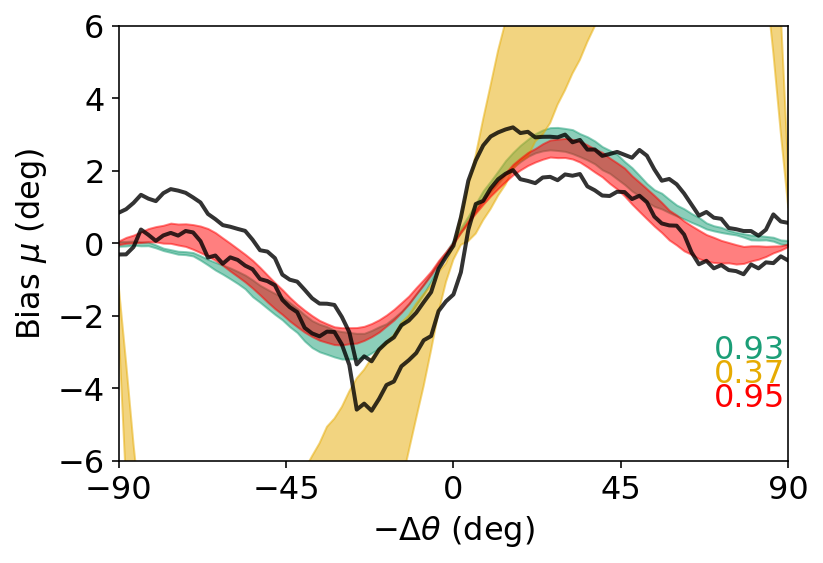

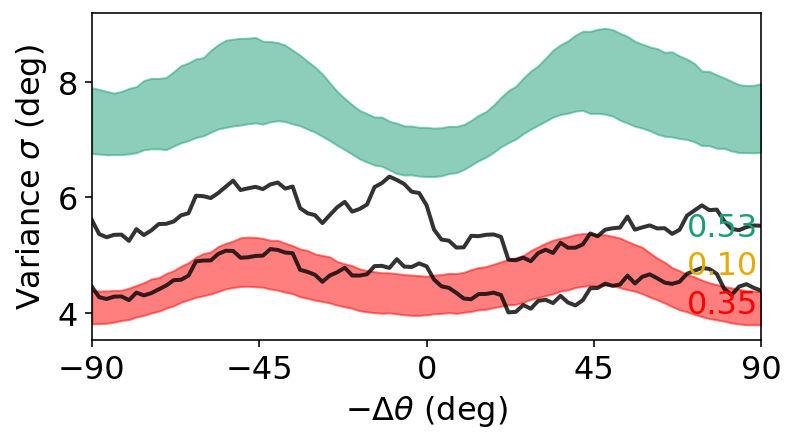

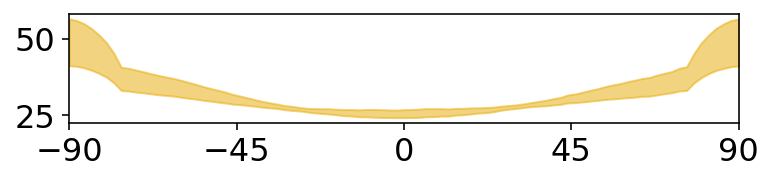

In [107]:
cols = np.array([ct[2],ct[0],ct[2],'r'])
plt.figure(figsize=(6,4))
for i in np.arange(1,4):
    sem_plot(bns,bias_mdl[:,i,:],do_line=0,color=cols[i],alpha=.5,label='Neural')
    rho_avg = scipy.stats.pearsonr(np.mean(bias_mdl[:,i,:],0),np.mean(s_percept_all[:,0,:],0))
    plt.annotate('%.2f'%rho_avg[0],(70,-2.5-i/1.5),color=cols[i])
sem_plot(bns,s_percept_all[:,0,:],outline=1,color='k',alpha=.8,linestyle='-',linewidth=2)
plt.xticks([-90,-45,0,45,90])
plt.xlim(-90,90)
plt.ylabel('Bias $\mu$ (deg)')
plt.ylim([-6,6])
plt.xlabel('$-\Delta\\theta$ (deg)')
# sav_fig('Fig5B_w32')
plt.show()

# var
plt.figure(figsize=(6,3))
for i in [1,2,3]:
    if i!=2:
        sem_plot(bns,var_mdl[:,i,:],do_line=0,color=cols[i],alpha=.5)
    rho_avg = scipy.stats.pearsonr(np.mean(var_mdl[:,i,:],0),np.mean(s_percept_all[:,1,:],0))
    plt.annotate('%.2f'%rho_avg[0],(70,6-i/1.5),color=cols[i])
    
sem_plot(bns,s_percept_all_w[:,1,:],outline=1,color='k',alpha=.8,linestyle='-',linewidth=2)
plt.xticks([-90,-45,0,45,90])
plt.xlim(-90,90)
plt.ylabel('Variance $\sigma$ (deg)')
plt.xlabel('$-\Delta\\theta$ (deg)')
# sav_fig('Fig5D1_w32')
plt.show()

plt.figure(figsize=(6,1))
for i in [2]:
    sem_plot(bns,var_mdl[:,i,:],do_line=0,color=cols[i],alpha=.5)


plt.xticks([-90,-45,0,45,90])
plt.xlim(-90,90)
# sav_fig('Fig5D2_w32')
plt.show()


# Single subject/ Model Plots

In [50]:
# make d_ori... confirm. than make d_rep

sim_d_ori = 90/pi*wrap_rad(np.concatenate(([0],model_out_all[subj]['Data']['ori_current'][:-1] - model_out_all[subj]['Data']['ori_current'][1:])))
used_d_ori = model_out_all[subj]['d_ori']
# plt.plot(sim_d_ori,used_d_ori,'k.')
d_dec = 90/pi*wrap_rad(np.concatenate(([0],model_out_all[subj]['DEC_NEURAL'][:-1] - model_out_all[subj]['Data']['ori_current'][1:])))

In [58]:
# generate no-noise estimates...
#- bin no-noise trials, use to plot [X]
#- compute CC []
#- compute CV CC []


cc_cv_no_noise = []
rho_no_noise,cc_no_noise = np.zeros((n_subj,4)),np.zeros((n_subj)) # can only do cc for neural
percept_fit_noNoise = np.zeros((n_subj,4,n_bns))


for si,subj in enumerate(subjs):
    d_ori = model_out_all[subj]['d_ori']
    SA = dat[(dat.subj==subj)&(dat.trial!=1)&(~np.isnan(dat.respCW))]
    eRecon = wrap(SA['estBNC'+roi].values-SA['orient0'].values-90)
    decRecon = SA['estBNC'+roi].values

    
    for i in range(4):
        if i==0:
            this_y = wrap_rad(model_out_all[subj]['DEC_NEURAL']-model_out_all[subj]['Data']['ori_current'])*90/pi
        else:
            this_y=model_out_all[subj]['DEC_RESP'][i-1,:]
        percept_fit_noNoise[si,i,:]=do_bining(bns,overlap,d_ori,this_y,flip=df)
       
        # cc_pool 
        if i==0: # neural 
            rho_no_noise[si,i] = scipy.stats.pearsonr(s_neural_all[si,0,:],percept_fit_noNoise[si,i,:])[0] # binned
            cc_no_noise[si] = cc.circ_corr(model_out_all[subj]['DEC_NEURAL']+pi,decRecon/90*pi) # raw
        else:
            rho_no_noise[si,i] = scipy.stats.pearsonr(s_percept_all_w[si,0,:],percept_fit_noNoise[si,i,:])[0] # binned
            

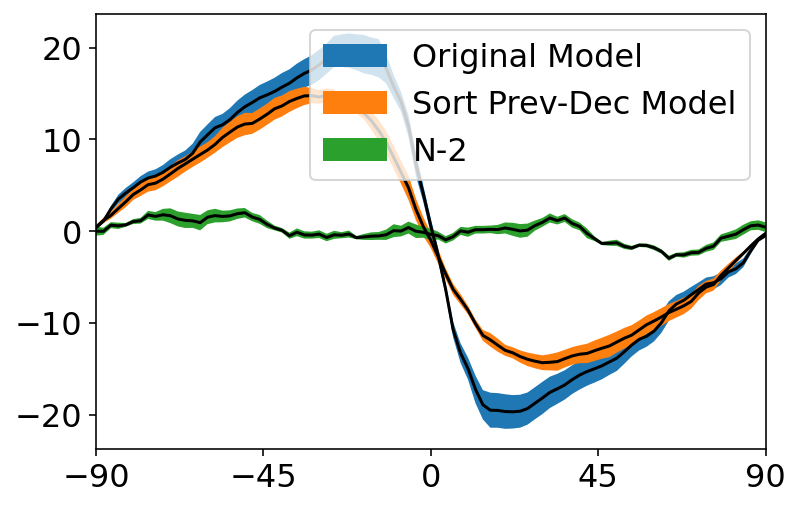

In [62]:
sem_plot(bns,percept_fit_noNoise[:,0,:],label='Original Model')
sem_plot(bns,percept_fit_noNoise0[:,0,:],label='Sort Prev-Dec Model')
sem_plot(bns,percept_fit_noNoise2[:,0,:],label='N-2')
plt.xlim(xl)
plt.xticks([-90,-45,0,45,90])
plt.legend()
plt.show()

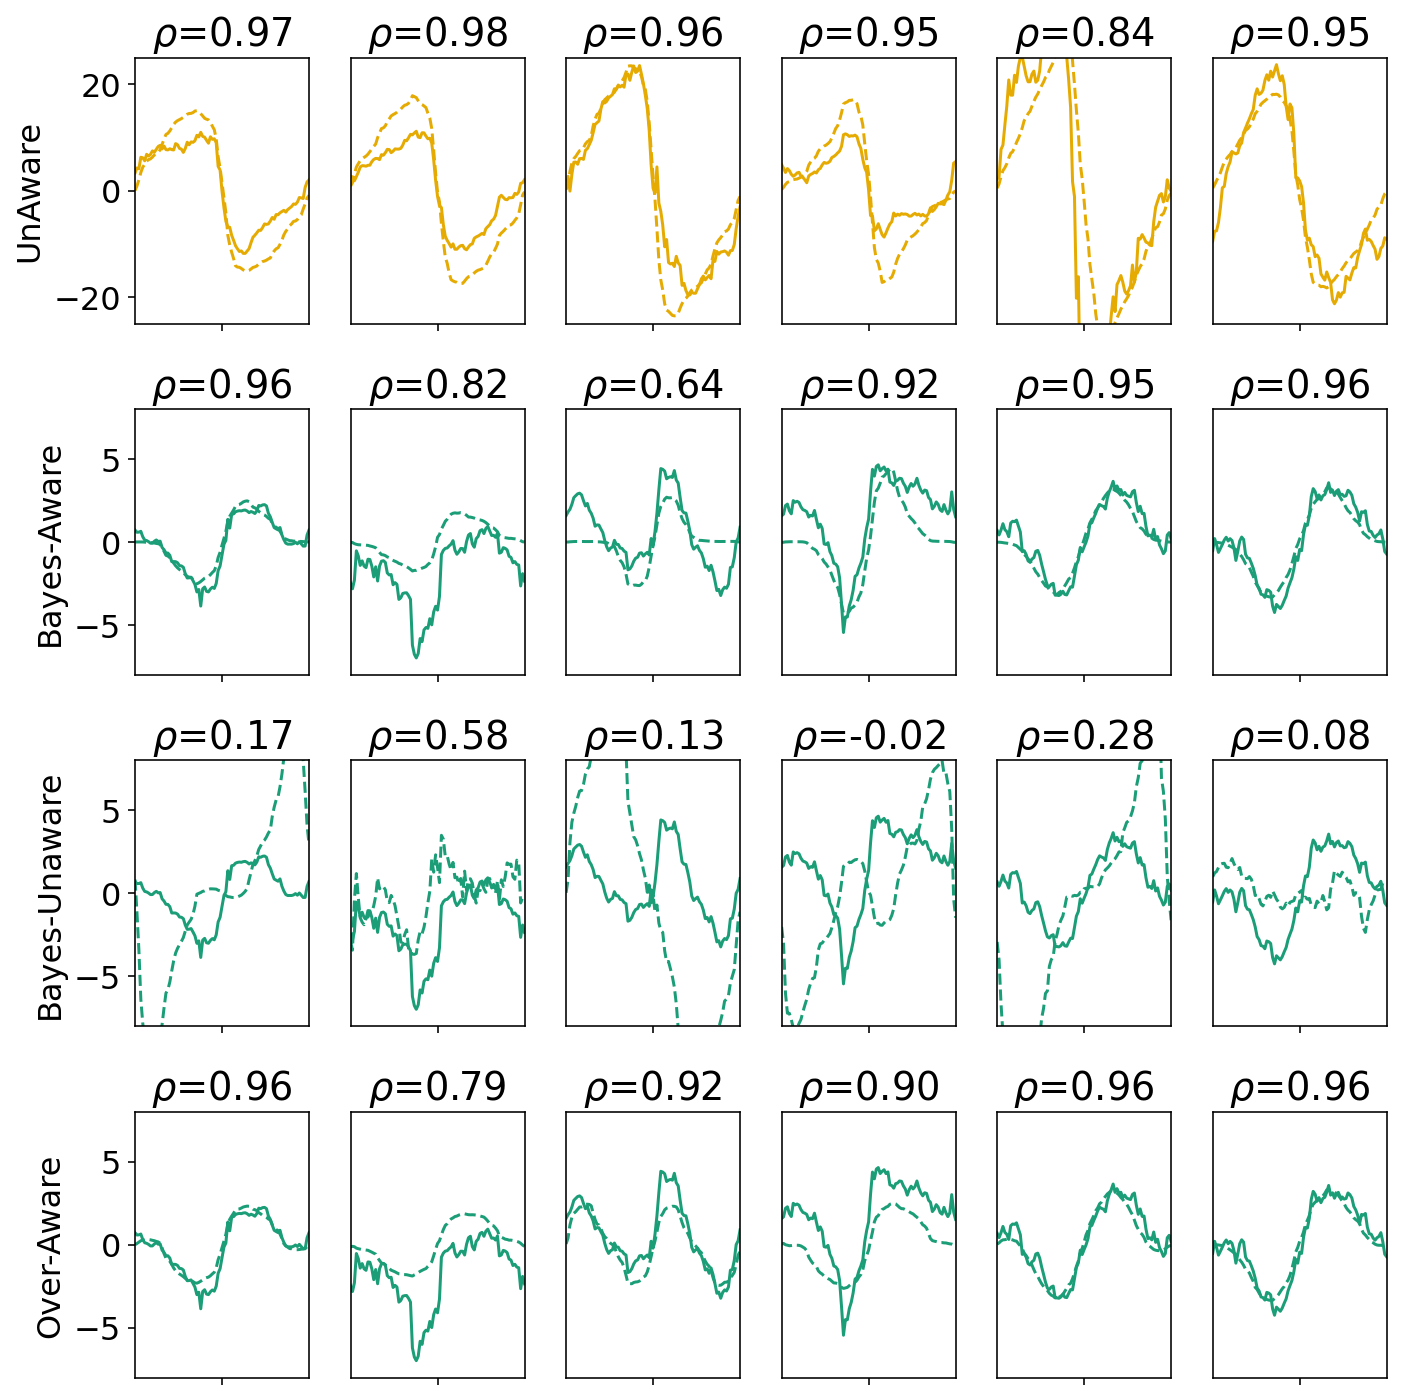

In [35]:
# really should just be 4 rows! 
plt.figure(figsize=(10,10))
nr,nc = 4,6
cnt=0
xl = (-90,90)
yl0 = np.array((-1,1))*25
yl1 = np.array((-1,1))*8
y_nams = ['UnAware','Bayes-Aware','Bayes-Unaware','Over-Aware']
rho_all = np.zeros((4,n_subj))
for i in range(4):
    for si in range(n_subj):
        cnt+=1
        plt.subplot(nr,nc,cnt)
        if i==0:
            this_emp = s_neural_all[si,0,:] # (NB that neural looked good w/ 4, 
#             this_fit = pred_bias[:,i,si]
#             this_fit = bias_all_cv[i,si]
            this_fit =percept_fit_noNoise[si,0,:]
            plt.plot(bns,this_emp,color=ct[2])
            plt.plot(bns,this_fit,'--',color=ct[2])
            plt.ylim(yl0)
            rho = scipy.stats.pearsonr(this_emp,this_fit)
            plt.title('$\\rho$=%.2f' %(rho[0]))
            
        else:
            this_emp =s_percept_all[si,0,:] # _w 
#             this_fit = pred_bias[:,i,si]
#             this_fit = bias_all_cv[i,si]
            this_fit =percept_fit_noNoise[si,i,:]
            plt.plot(bns,this_emp,color=ct[0])
            plt.plot(bns,this_fit,'--',color=ct[0])
            plt.ylim(yl1)
            try:
                rho = scipy.stats.pearsonr(this_emp,this_fit)
            except:
                rho=[np.nan]
            plt.title('$\\rho$=%.2f' %(rho[0]))
#             plt.title('$R^2$=%.2f' %(rho[0]**2))
        if si!=0:
            plt.yticks([])
        else:
            plt.ylabel(y_nams[i])
        plt.xlim(xl)
        plt.xticks([0],[''])
        rho_all[i,si] = rho[0]
plt.tight_layout()
# sav_fig('Fig9_noFold_w32')
plt.show()

In [97]:
# correlation by model
rho_all = np.zeros((n_subj,3))
for si in range(n_subj):
    for i,mi in enumerate([2,1,3]):
        this_emp =s_percept_all[si,0,:]
        this_fit =percept_fit_noNoise[si,mi,:]
        rho_all[si,i] = scipy.stats.pearsonr(this_emp,this_fit)[0]
rho_z = np.arctanh(rho_all)


In [98]:
for i,j in ((0,1),(0,2),(1,2)):
    this_t = scipy.stats.ttest_rel(rho_z[:,i],rho_z[:,j])
    print(this_t)

Ttest_relResult(statistic=-5.350635505265665, pvalue=0.0030625944409112447)
Ttest_relResult(statistic=-6.660452222288105, pvalue=0.0011513984436730994)
Ttest_relResult(statistic=-0.7550782607641958, pvalue=0.48422986848567473)


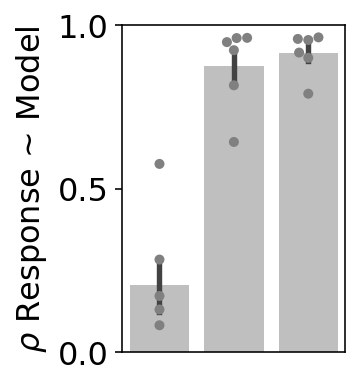

In [99]:
plt.figure(figsize=(2,3))
sns.barplot(data=rho_all,ci=68,color='gray',alpha=.5)
sns.swarmplot(data=rho_all,color='gray')
plt.ylabel('$\\rho$ Response ~ Model')
plt.xticks([])
plt.ylim([0,1])
plt.yticks([0,.5,1])
# sav_fig('Fig8_corr')
plt.show()

# model variance analysis

# Uncertainty distribution

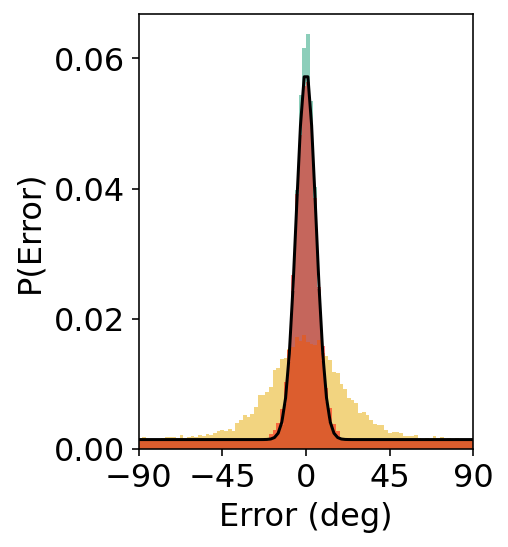

[0.002436026467007844, 0.16697805033613572, 0.0035258326120752646]


In [76]:
# want histograms of error and individual of err f(d_ori)
# also quantititative analysis of how error matches up
cols = np.array([ct[2],ct[0],ct[2],'r'])
si=2
al=.5
bin_centers = bns[:-1]+1
this_fit_sd = fit_sd_all[si]
do_GR = 1
labs = ['B-Aware','B-Unaware','OverAware']
# emp_precision = scipy.stats.norm(0,this_fit_sd).pdf(bin_centers)
# plt.figure(figsize=(2,3))
plt.figure(figsize=(3,4))
this_precision = scipy.stats.norm(0,this_fit_sd)
if do_GR:
    emp_precision = this_precision.pdf(bin_centers)*(1-GUESS_RATE)+GUESS_RATE/180
else:
    emp_precision = this_precision.pdf(bin_centers)
plt.plot(bin_centers,emp_precision,'k',label='Estimated')
these_JS =[]
for i in range(3):
    this_E=E_out_sim_cv[si][:,i+1,:].flatten().copy()
    if do_GR:
        n_guess = int(len(this_E)*GUESS_RATE)
        this_E_use = np.concatenate((this_E,np.linspace(-90,90,n_guess)))
    else:
        this_E_use=this_E
    mdl_precision = np.histogram(this_E_use,bns,density=1)[0]
    this_JS = scipy.spatial.distance.jensenshannon(mdl_precision,emp_precision,2)**2
    plt.hist(this_E_use,bns,alpha=al,density=1,label=labs[i]+' '+str(round(this_JS,4)),color=cols[i+1])
    these_JS.append(this_JS)
# plt.legend(bbox_to_anchor=(1,.5))

# plt.xticks([-90,-45,0,45,90])
plt.xticks([-90,-45,0,45,90])
plt.xlim([-90,90])
plt.xlabel('Error (deg)')
plt.ylabel('P(Error)')
# sav_fig('Fig_mdlDist_thin')
plt.show()
print(these_JS)

In [ ]:
# thin version

In [256]:
# get likelihood of overall errors! 
LL_Errors_all = np.zeros((n_subj,3))
JS_dist = np.zeros((n_subj,3))
for si,subj in enumerate(subjs):
    this_fit_sd = fit_sd_all[si]
    this_precision = scipy.stats.norm(0,this_fit_sd)
    if do_GR:
        emp_precision = this_precision.pdf(bin_centers)*(1-GUESS_RATE)+GUESS_RATE/180
    else:
        emp_precision = this_precision.pdf(bin_centers)
    for i in range(3):
        this_E=E_out_sim_cv[si][:,i+1,:].flatten().copy()
        if do_GR:
            n_guess = int(len(this_E)*GUESS_RATE)
            this_E_use = np.concatenate((this_E,np.linspace(-90,90,n_guess)))
        else: this_E_use=this_E
        LL_Errors_all[si,i]=np.sum(np.log(this_precision.pdf(this_E_use)))
        mdl_precision = np.histogram(this_E_use,bns,density=1)[0]
        
        JS_dist[si,i] = scipy.spatial.distance.jensenshannon(mdl_precision,emp_precision,2)

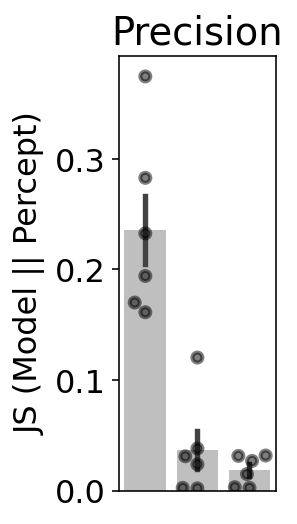

Ttest_relResult(statistic=10.953501637094147, pvalue=0.00011028529666153989)
Ttest_relResult(statistic=1.1024700483448562, pvalue=0.32047328144835)
Ttest_relResult(statistic=6.8712836958558805, pvalue=0.0009983603980778693)


In [270]:
# JS_div = JS_dist**2
# JS_div = JS_div[[1,0,2],:]
JS_div= np.stack((JS_dist[:,1],JS_dist[:,0],JS_dist[:,2])).T**2
plt.figure(figsize=(1.4,4))
sns.barplot(data=JS_div,ci=68,color='gray',alpha=.5)#,linestyles='None')
sns.swarmplot(data=JS_div,color='k',alpha=.5,linewidth=2,edgecolor='k')
# plt.plot([0,1,2],JS_div.T,'gray',alpha=.5)
# plt.xticks([0,1,2],['B-Aware','B-unAware','overAware'],rotation=70)
# plt.ylabel('Log-Likelihood')
plt.ylabel('JS (Model || Percept)')
plt.xlim((-.5,2.5))
plt.title('Precision')
# sav_fig('Fig10B')
# sav_fig('NEW_F4_unAwareMDLs_precisionBars_wGR')
plt.xticks([])
# sav_fig('JS_BAR_NEW')
plt.show()

print(scipy.stats.ttest_rel(JS_div[:,0],JS_div[:,1])) # Bayes
print(scipy.stats.ttest_rel(JS_div[:,1],JS_div[:,2])) # good ones
print(scipy.stats.ttest_rel(JS_div[:,0],JS_div[:,2])) # awareness

# split

In [261]:
# get unc split @ 30 deg
thresh = 30
# var_thresh = np.zeros((2,2,n_subj))
mdl_names = ['Neural','a_a','n_a','a_a_2']
var_thresh = pd.DataFrame()
for si,subj in enumerate(subjs):
    this_E = E_out_sim_cv[si]
    n_cv,*_=this_E.shape
    cat_E = np.concatenate([this_E[i,:,:] for i in range(n_cv)],1)
    cat_theta = np.concatenate([theta_sim for i in range(n_cv)])
    for bn in range(2):
        if bn==0:
            these_ind = np.abs(cat_theta)<(thresh/90*pi)
            bin_name = 'Close'
        else:
            these_ind = np.abs(cat_theta)>(thresh/90*pi)
            bin_name = 'Far' 
        for i in range(4):
            this_e = cat_E[i,these_ind].copy()
            this_e[cat_theta[these_ind]>0]*=-1
            if i==0:
                sd = circ_std(this_e)
            else:
                sd = np.nanstd(this_e)
            var_thresh=var_thresh.append({'subj':subj,'Dist':bin_name,'mdl':mdl_names[i],'SD':sd},ignore_index=1)

In [259]:
def quick_t(vals): 
    this_t =scipy.stats.ttest_rel(vals[0],vals[1])
    print('T(5)=%.2f p=%.6f' %(this_t[0],this_t[1]/2))
    
# df_thresh_match_all =pd.read_pickle('PrecsionSplit30.pickle')
# df_roi_thresh_match_all=pd.read_pickle('NeuralSplit30.pickle')
df_thresh_match_all = pd.read_hdf('PrecsionSplit30.hdf','percept')
df_roi_thresh_match_all = pd.read_hdf('PrecsionSplit30.hdf','neural')

Neural
T(5)=3.93 p=0.005512
a_a
T(5)=-1.90 p=0.058243
a_a_2
T(5)=-5.43 p=0.001431
BEH
T(5)=-5.73 p=0.001129
Decoded Neural
T(5)=13.91 p=0.000017


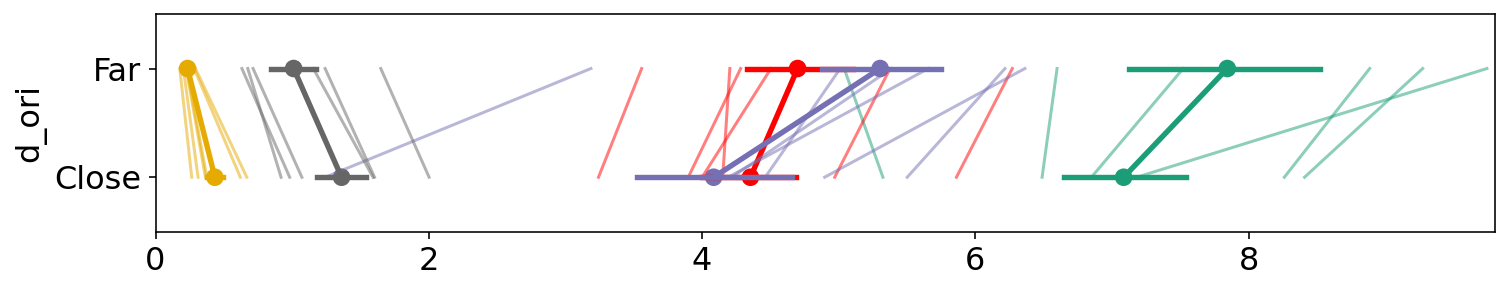

Bayes Unaware
T(5)=-2.25 p=0.037098


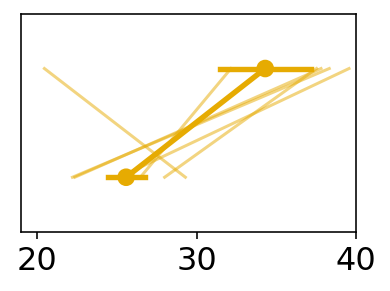

In [279]:
mdl_names = ['Neural','a_a','n_a','a_a_2']
plt.figure(figsize=(12,2))
for mi in [0,1,3]: # 0
    mdl=mdl_names[mi]
    ind_use = (var_thresh.mdl==mdl)
    sns.pointplot(data=var_thresh[ind_use],x='SD',y='Dist',ci=68,color=cols[mi])
    vals = np.array((var_thresh.loc[(var_thresh.Dist=='Close')&ind_use,'SD'].values,
                 var_thresh.loc[(var_thresh.Dist=='Far')&ind_use,'SD'].values))
    print(mdl)
    quick_t(vals)
    plt.plot(vals,[0,1],color=cols[mi],alpha=.5)
    
    
sns.pointplot(data=df_thresh_match_all,y='d_ori',x='sd',ci=68,color=ct[1])
vals = np.array((df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Close'),'sd'].values,
                 df_thresh_match_all.loc[(df_thresh_match_all.d_ori=='Far'),'sd'].values))
plt.plot(vals,[0,1],color=ct[1],alpha=.5)
print('BEH')
quick_t(vals)
this_df_roi = df_roi_thresh_match_all[(df_roi_thresh_match_all.roi==roi)&(df_roi_thresh_match_all.thresh==30)].copy()
sns.pointplot(data=this_df_roi,y='d_ori',x='sd',ci=68,color=ct[3])

vals = np.array((this_df_roi.loc[(this_df_roi.d_ori=='Close'),'sd'].values,
                 this_df_roi.loc[(this_df_roi.d_ori=='Far'),'sd'].values))
plt.plot(vals,[0,1],color=ct[3],alpha=.5)
print('Decoded Neural')
quick_t(vals)

plt.ylim(-.5,1.5)
plt.xlim(0,9.8)
plt.xlabel('')

sav_fig('Fig10_wide')
# sav_fig('NEW_F4_wideUnc30deg_2')
plt.show()

plt.figure(figsize=(3,2))
mi=2
mdl=mdl_names[mi]
ind_use = (var_thresh.mdl==mdl)
sns.pointplot(data=var_thresh[ind_use],x='SD',y='Dist',ci=68,color=cols[mi])
vals = np.array((var_thresh.loc[(var_thresh.Dist=='Close')&ind_use,'SD'].values,
             var_thresh.loc[(var_thresh.Dist=='Far')&ind_use,'SD'].values))
print('Bayes Unaware')
quick_t(vals)
plt.plot(vals,[0,1],color=cols[mi],alpha=.5)
plt.ylim(-.5,1.5)
plt.ylabel('')
plt.yticks([])

plt.xlabel('')
plt.xlim(19,40)
sav_fig('Fig10_UA')
# sav_fig('NEW_F4_unAwareUnc30deg_2')
# sav_fig('F4_unAwareUnc30deg_2')
plt.show()

# Model Likelhood

In [57]:
MF_d

,subj,cc_recon,cc_null,cc_residuals,lik_a_a,lik_a_n,lik_a_a_2,lik_binary,R2_dec,R2_eRecon,RMSE_dec,RMSE_dec_null,RMSE_eRecon,RMSE_eRecon_null,LR_BAware,LR_Bunaware,LR_2Aware
0,UCSD054,0.503928,0.482622,0.279729,-480.599622,-608.566299,-481.027705,-776.599390,0.744778,0.079456,25.783894,51.037495,25.783894,26.873623,295.999768,168.033091,295.571684
1,UCSD060,0.560618,0.543790,0.335479,-522.140942,-517.715342,-517.771786,-834.976694,0.787799,0.070829,23.738855,51.533038,23.738855,24.627028,312.835752,317.261352,317.204908
2,UCSD061,0.200906,0.149817,0.167347,-471.953324,-470.679053,-467.575754,-843.142688,0.481909,0.107997,36.873734,51.228790,36.873734,39.042175,371.189364,372.463635,375.566934
3,UCSD062,0.541957,0.542335,0.238141,-461.315680,-510.376648,-464.165483,-740.677107,0.758845,0.041128,24.789238,50.479467,24.789238,25.315293,279.361427,230.300459,276.511625
4,UCSD063,0.044495,0.022588,0.045070,-407.188487,-435.289744,-406.199121,-694.224085,0.190706,0.052465,45.585688,50.672853,45.585688,46.830725,287.035598,258.934341,288.024965
5,UCSD064,0.159744,0.128821,0.124085,-480.356326,-484.404634,-481.455076,-821.374733,0.410031,0.077743,38.908335,50.655684,38.908335,40.515071,341.018407,336.970099,339.919657


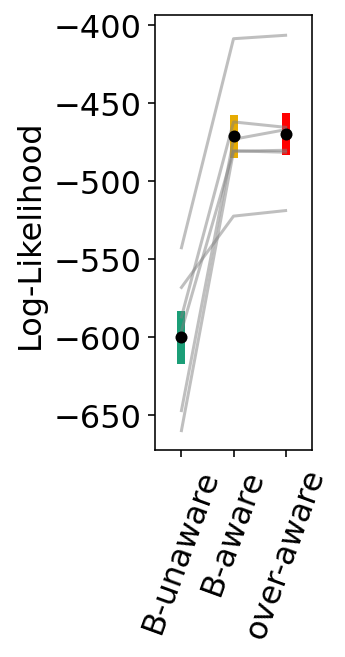

[Ttest_1sampResult(statistic=6.529494236462104, pvalue=0.0012604389229095199), Ttest_1sampResult(statistic=-0.9853257981819371, pvalue=0.36971209875290756), Ttest_1sampResult(statistic=-6.5547247096626675, pvalue=0.0012385135802835596)]


In [77]:
MF_d =model_performance_df.copy()

MF_d['LR_BAware'] = MF_d.lik_a_a-MF_d.lik_binary 
MF_d['LR_Bunaware'] = MF_d.lik_a_n-MF_d.lik_binary 
MF_d['LR_2Aware'] = MF_d.lik_a_a_2-MF_d.lik_binary 


# var_plot = ['LR_null', 'LR_unaware', 'LR_2Aware']
# var_plot = ['LR_unaware', 'LR_2Aware']
var_plot = ['LR_BAware','LR_Bunaware','LR_2Aware']

df_untidy = pd.DataFrame()
all_df=[]
for var in var_plot:
    this_df = MF_d[['subj']].copy()
    this_df['variable'] = MF_d[var]
    this_df['lab'] = var
    all_df.append(this_df)
all_df = pd.concat(all_df)

plt.figure(figsize=(1.4,4))
# vals = model_performance_df[['lik_a_a','lik_a_n','lik_a_a_2']].values
vals = model_performance_df[['lik_a_n','lik_a_a','lik_a_a_2']].values

# plt.plot([0,1,2],vals.T,'o',color='gray')
plt.plot([0,1,2],vals.T,'-',color='gray',alpha=.5)
# sns.pointplot(data=vals,ci=68,color='gray',linestyles='None')
foo = cols.copy()
foo[3] = np.array([1,0,0,1])
plt.errorbar([0,1,2],np.mean(vals,0),std_e(vals),ecolor=cols[1:],linestyle='',linewidth=4,marker='o',markerfacecolor='k',markeredgecolor='None')
# sns.swarmplot(data=model_performance_df[['lik_a_a','lik_a_n','lik_a_a_2']].values,color=ct[0],dodge=0,alpha=.5,edgecolor='k',linewidth=1)
plt.xticks([0,1,2],['B-unaware','B-aware','over-aware'],rotation=70)
plt.ylabel('Log-Likelihood')
plt.xlim((-.5,2.5))

# sav_fig('Fig8_LogLik')
# sav_fig('NEW_F4_LL')
plt.show()

# t-test between likelihood ratios
LR_a_aXa_n=2*(model_performance_df.lik_a_a-model_performance_df.lik_a_n).values
LR_a_aXa_a_2=2*(model_performance_df.lik_a_a-model_performance_df.lik_a_a_2).values
LR_a_nXa_a_2=2*(model_performance_df.lik_a_n-model_performance_df.lik_a_a_2).values

LR_ALL = [LR_a_aXa_n,LR_a_aXa_a_2,LR_a_nXa_a_2]
ps = [scipy.stats.ttest_1samp(this_L,0) for this_L in LR_ALL]
print(ps)


In [74]:
# get bits...
# need # of trials/ subject
trials_subj = dat.groupby('subj').trial.size().values
bits_a_a = (model_performance_df['lik_a_a'].values-model_performance_df['lik_a_n'].values)/(trials_subj*np.log(2))
bits_a_oa = (model_performance_df['lik_a_a_2'].values-model_performance_df['lik_a_n'].values)/(trials_subj*np.log(2))
print('Bayes Aware %.2f +/- %.2f' %(np.mean(bits_a_a),std_e(bits_a_a)))
print('Over Aware %.2f +/- %.2f' %(np.mean(bits_a_oa),std_e(bits_a_oa)))

Bayes Aware 0.22 +/1 0.03
Over Aware 0.23 +/1 0.03


# Model performance neural data

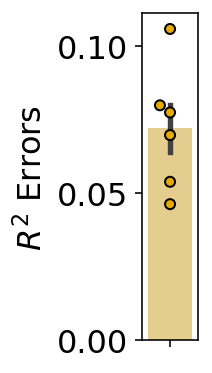

Ttest_1sampResult(statistic=8.342725219146834, pvalue=0.00040469729668170723)

In [267]:
vp = 'R2_eRecon'
# vp = 'cc_residuals'
b0 = MF_d[vp].mean()
v1 = MF_d[vp].std()/np.sqrt(len(MF_d))

plt.figure(figsize=(.5,3))
# plt.errorbar(0,b0,v1,color=ct[2])
# plt.bar(0,b0,color=ct[2],alpha=.5)
# sns.swarmplot(y=vp,data=MF_d,color=ct[2],edgecolor='k',linewidth=1)
# plt.show()
sns.barplot(data=MF_d[vp],ci=68,color=ct[2],alpha=.5)
sns.swarmplot(y=MF_d[vp],color=ct[2],edgecolor='k',linewidth=1)
plt.ylabel('$R^2$ Errors')
plt.yticks([0,.05,.1])#,['0.0','.05','.01'])
# sav_fig('F8_R2_Err')
plt.show()
scipy.stats.ttest_1samp(MF_d[vp],0)

T(5) -3.54 (p=0.008)
Null: 0.31 +/- 0.088
Aware: 0.34 +/- 0.084
dRho=-0.02 +/- 0.00611


<ipython-input-268-cdf9b8857bf9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df['variable'] = MF_d[var]
<ipython-input-268-cdf9b8857bf9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_df['lab'] = var


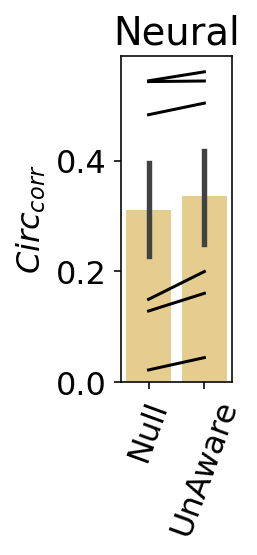

In [268]:
df_untidy1 = pd.DataFrame()
var_plot = ['cc_null','cc_recon']
all_df1=[]
for var in var_plot:
    this_df = MF_d[['subj']]
    this_df['variable'] = MF_d[var]
    this_df['lab'] = var
    all_df1.append(this_df)
all_df1 = pd.concat(all_df1)

plt.figure(figsize=(1,3))
vals = np.array((MF_d['cc_null'].values,MF_d['cc_recon'].values))
sns.barplot(data=all_df1,x='lab',y='variable',ci=68,color=ct[2],alpha=.5)
plt.plot([0,1],vals,'k')

plt.xlim(-.5,1.5)
plt.xticks([0,1],['Null','UnAware'],rotation=70)
plt.xlabel('')
plt.ylabel('$Circ_{corr}$')
plt.title('Neural')
d_vals = vals[0,:]-vals[1,:]
ts = scipy.stats.ttest_1samp(d_vals,0)
print('T(%d) %.2f (p=%.3f)' %(len(MF_d)-1,ts[0],ts[1]/2))
print('Null: %.2f +/- %.3f' % (np.mean(vals[0]), std_e(vals[0]) ) )
print('Aware: %.2f +/- %.3f' % (np.mean(vals[1]), std_e(vals[1]) ) )
print('dRho=%.2f +/- %.5f' %(np.mean(d_vals),std_e(d_vals)))
# sav_fig('F8_CircCorr')
# sav_fig('Fig4C_dCircCorr')
plt.show()


# Model Efficiency

In [39]:
# n_pull = 10000
n_sim = 1000
theta_sim = np.linspace(-pi,pi,n_sim)
data = {'ori_prev':np.zeros((1,len(theta_sim))),'ori_current':theta_sim,'ori_dec':np.nan,'probe':np.nan,'resp':np.nan}

n_pull = 1000
act_all,pull_act = [],[]
for si, subj in enumerate(subjs):
    
    this_act = E_act_sim_cv[si]
    n_cv,*_ = this_act.shape
    params_all = DEC_ALL[subj]['params']
    this_activity = np.zeros((n_cv,2,2,n_pull)) # adapt/noAdapt, iid/prior, samples
    for cv in range(n_cv):
        act_this = E_act_sim_cv[si][cv,:,:] 
        this_lam = params_all[cv,1,1]
        this_prior = cf(theta_sim,s_1=0,lam=this_lam) #
        pull_prior = inv_cdf(np.cumsum(this_prior)/len(theta_sim),np.random.rand(n_pull))
        for i in range(2): #adapt/no
            this_activity[cv,i,0,:] = act_this[i,:]
            this_activity[cv,i,1,:] = act_this[i,pull_prior]
        this_act_cat = np.concatenate([this_activity[j,:,:,:] for j in range(n_cv)],2)
    act_all.append(this_act_cat)


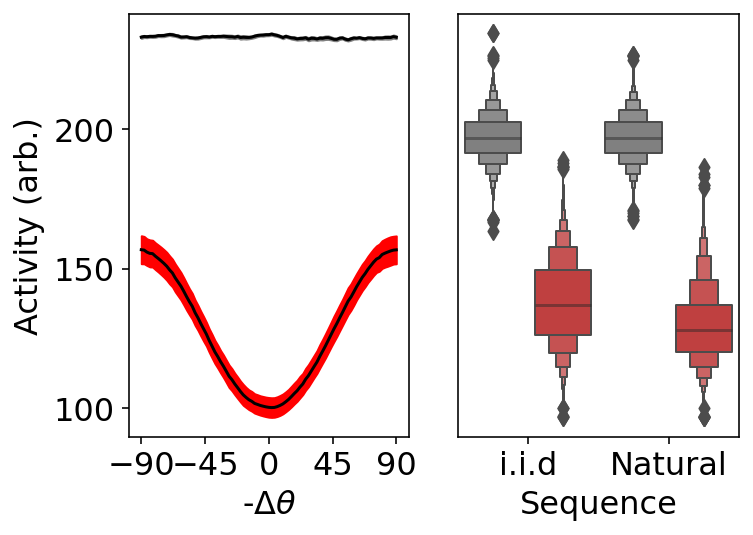

Is adapted activity more efficient when stimulus sequence is naturalistic?
Ttest_relResult(statistic=472.30222455320825, pvalue=0.0)


In [40]:
this_pal = ['gray','r','gray','r']
si=0
yl = (210,560)
plt.figure(figsize=(5.5,4))
plt.subplot(121)
sem_plot(bns,act_all_subj[si][0],color='gray')
sem_plot(bns,act_all_subj[si][1],color='r')
plt.xticks([-90,-45,0,45,90])
plt.ylabel('Activity (arb.)')
# plt.ylim(yl)
plt.xlabel('-$\Delta\\theta$')
plt.subplot(122)


subj_activity = np.reshape(act_all[si],(4,-1))
subj_activity = subj_activity[[0,2,1,3],:]
sns.boxenplot(data=subj_activity.T,palette=this_pal,saturation=.5)
plt.xticks([.5,2.5],['i.i.d','Natural'])
plt.xlabel('Sequence')
# plt.ylim(yl)
plt.yticks([])
plt.tight_layout()
# sav_fig('NEW_Fig4_activity')
plt.show()

# stats for activity 
print('Is adapted activity more efficient when stimulus sequence is naturalistic?')
t0 = scipy.stats.ttest_rel(subj_activity[0,:],subj_activity[1,:])
t1 = scipy.stats.ttest_rel(subj_activity[2,:],subj_activity[3,:])
print(t1)

In [ ]:
# END